In [34]:
#we are going to import the geracao dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import os

In [35]:
dataset = pd.read_csv('data.csv')
#del dataset["Unnamed: 0"]
#print(dataset.head)

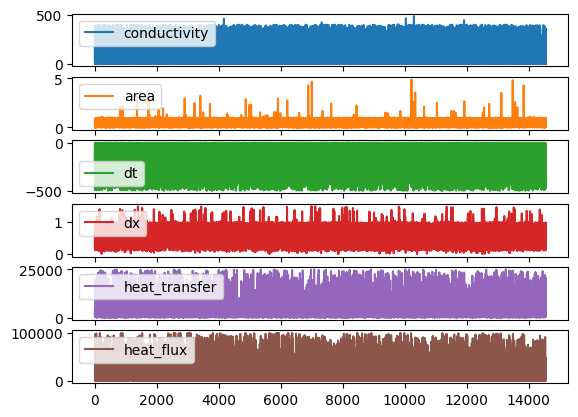

In [36]:
#we are going to plot every single data in the dataset to see how it looks like
dataset.plot(subplots=True)
plt.show()
#saving the plot as a image

In [37]:
#our y or target will be the heat_flx
target = dataset["heat_flux"]
#our x or features will be the rest of the dataset
dados = dataset[["conductivity","area","dt","dx","heat_transfer"]]

In [38]:
print(dados)

       conductivity      area          dt        dx  heat_transfer
0         51.357062  0.015554 -181.769461  0.197560     734.958420
1        391.073441  0.618634  -15.855892  0.929270    4128.012785
2        318.077965  0.553035   -3.452905  0.250979    2420.096815
3          0.199998  0.856840 -492.222512  0.215136     392.080500
4        168.994813  0.300090   -2.184830  0.123006     900.773543
...             ...       ...         ...       ...            ...
14549      3.953897  0.854906 -215.170306  0.328512    2213.983037
14550    191.609372  0.860584  -99.839186  0.797456   20644.484436
14551    188.388434  0.439605 -245.220095  0.991502   20482.327567
14552      1.001367  0.991186 -257.820831  0.299304     854.974578
14553     57.006281  0.543128  -70.098256  0.779525    2784.210834

[14554 rows x 5 columns]


In [39]:
print(target)

0        47252.277736
1         6672.787746
2         4376.029580
3          457.589197
4         3001.679916
             ...     
14549     2589.739125
14550    23988.932301
14551    46592.583489
14552      862.576931
14553     5126.252232
Name: heat_flux, Length: 14554, dtype: float64


In [40]:
target = np.array(target)
dados = np.array(dados)

In [41]:
print(dados)

[[ 5.13570618e+01  1.55539258e-02 -1.81769461e+02  1.97559692e-01
   7.34958420e+02]
 [ 3.91073441e+02  6.18633912e-01 -1.58558919e+01  9.29269512e-01
   4.12801278e+03]
 [ 3.18077965e+02  5.53034839e-01 -3.45290540e+00  2.50979365e-01
   2.42009681e+03]
 ...
 [ 1.88388434e+02  4.39604891e-01 -2.45220095e+02  9.91501784e-01
   2.04823276e+04]
 [ 1.00136652e+00  9.91186464e-01 -2.57820831e+02  2.99304491e-01
   8.54974578e+02]
 [ 5.70062809e+01  5.43127944e-01 -7.00982559e+01  7.79524823e-01
   2.78421083e+03]]


In [42]:
#scaling both the target and the features, keep in mind that we can reverse the scaling later
scaler = StandardScaler()
dados = scaler.fit_transform(dados)
target = scaler.fit_transform(target.reshape(-1,1))

In [43]:
X_train_full, x_test, y_train_full, y_test = train_test_split(dados, target, test_size=0.25, random_state=42)


In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [45]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3,activation="tanh", input_shape=[5]):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation, **options))
        options = {}
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [46]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\lucca\AppData\Local\Temp\ipykernel_12968\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [47]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    "n_neurons": np.arange(10, 256),
    "learning_rate": reciprocal(3e-5, 3e-2),
    "activation": ["tanh"],
}

In [48]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5,n_jobs=1,cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=75,
                    validation_data=(X_valid, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=5,monitor="val_loss")],verbose=2)

c:\Users\lucca\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/75
171/171 - 1s - loss: 0.4605 - val_loss: 0.4327 - 717ms/epoch - 4ms/step
Epoch 2/75
171/171 - 0s - loss: 0.4095 - val_loss: 0.4251 - 355ms/epoch - 2ms/step
Epoch 3/75
171/171 - 0s - loss: 0.4050 - val_loss: 0.4174 - 304ms/epoch - 2ms/step
Epoch 4/75
171/171 - 0s - loss: 0.3987 - val_loss: 0.4135 - 387ms/epoch - 2ms/step
Epoch 5/75
171/171 - 0s - loss: 0.3920 - val_loss: 0.4107 - 366ms/epoch - 2ms/step
Epoch 6/75
171/171 - 0s - loss: 0.3843 - val_loss: 0.4004 - 393ms/epoch - 2ms/step
Epoch 7/75
171/171 - 0s - loss: 0.3762 - val_loss: 0.3906 - 362ms/epoch - 2ms/step
Epoch 8/75
171/171 - 0s - loss: 0.3648 - val_loss: 0.3777 - 441ms/epoch - 3ms/step
Epoch 9/75
171/171 - 0s - loss: 0.3524 - val_loss: 0.3627 - 481ms/epoch - 3ms/step
Epoch 10/75
171/171 - 0s - loss: 0.3346 - val_loss: 0.3461 - 279ms/epoch - 2ms/step
Epoch 11/75
171/171 - 0s - loss: 0.3132 - val_loss: 0.3259 - 284ms/epoch - 2ms/step
Epoch 12/75
171/171 - 0s - loss: 0.2903 - val_loss: 0.2948 - 378ms/epoch - 2ms/step
E

In [ ]:
model = rnd_search_cv.best_estimator_.model

In [ ]:
hist = model.history.history

In [ ]:
rnd_search_cv.best_params_

In [ ]:
model.summary()

In [ ]:
#ploting the loss and the validation loss
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()


In [ ]:
mse_test = model.evaluate(x_test, y_test) #mse

In [ ]:
y_pred = model.predict(x_test)
y_pred = y_pred.flatten()

In [ ]:
#we have to convert the y_test back to its original shape
#we are going to inverse the scaling of the y_pred, since we scaled it before
#inverse scaling both the y_pred and the y_test
#y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
#y_test = scaler.inverse_transform(y_test.reshape(-1,1))

plt.plot(y_pred, color="red", label="pred")
plt.plot(y_test, color="green", label="actual")
plt.legend(loc="upper left")
plt.show()

In [ ]:
#plotting just the first 100 predictions and values
plt.plot(y_pred[:100], color="red", label="pred")
plt.plot(y_test[:100], color="green", label="actual")
plt.legend(loc="upper left")
plt.show()


In [ ]:
mean_squared_error(y_test, y_pred)

In [ ]:
#showing the predictions of the first 10 values 
y_pred_inversed = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_inversed = scaler.inverse_transform(y_test.reshape(-1,1))
for i in range(10):
    print("pred: ", y_pred_inversed[i], "actual: ", y_test_inversed[i])


In [ ]:
dataset_test = pd.read_csv('teste.csv')

In [ ]:
#setting up the target and the data
target = dataset_test["heat_flux"]
dados = dataset_test[['conductivity','area','dt','dx','heat_transfer']]
#scaling the data
scaler = StandardScaler()
dados = scaler.fit_transform(dados)
target = target.values.reshape(-1,1)
target = scaler.fit_transform(target)


In [ ]:
new_mse_test = model.evaluate(dados, target)

In [ ]:
print("mse test: ", mse_test)
print("mse new test: ", new_mse_test)

In [ ]:
#the name of the model will include its amount of hidden layers, its amount of neurons and the amount of indexes in the dataset
#that were used to train it
amount = len(dataset)

name = "model_" + str(rnd_search_cv.best_params_["n_hidden"]) + "_" + str(rnd_search_cv.best_params_["n_neurons"]) +  "_"+ str(amount) + ".h5"
model.save(name)
print("model saved")

In [ ]:
#Plotting the predictions and the real values
y_pred_inversed = scaler.inverse_transform(y_pred.reshape(-1,1))
target_inversed = scaler.inverse_transform(target.reshape(-1,1))

for i in range(10):
    print("pred: ", y_pred_inversed[i], "actual: ", target_inversed[i])

In [ ]:
plt.plot(y_pred_inversed, color="red", label="pred")
plt.plot(target_inversed, color="green", label="actual")
plt.legend(loc="upper left")
plt.show()